In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.3
numpy 1.26.4
pandas 2.3.0
sklearn 1.7.0
torch 2.7.1+cpu
cpu


# MosesTokenizer预处理 subword-nmt分词

In [2]:
# !sh data_multi30k.sh wmt16 wmt16 de en

Total sentences: 29000
Min length: 2
Max length: 47
Mean length: 13.03
Median length: 12.0


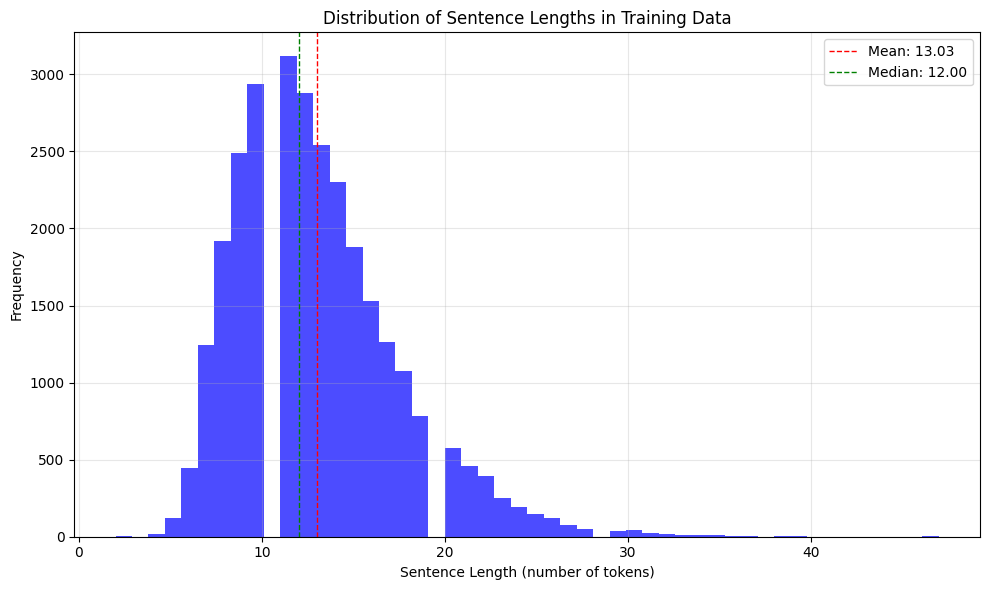

In [3]:
# 读取训练源文件并分析句子长度
with open("wmt16/train_src.bpe", "r", encoding="utf8") as file:
    lines = file.readlines()

# 分割每行并计算长度
lengths = [len(line.strip().split()) for line in lines]

# 创建句子长度的直方图
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50, alpha=0.7, color='blue')
plt.xlabel('Sentence Length (number of tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths in Training Data')
plt.grid(True, alpha=0.3)

# 添加一些统计数据作为文本
plt.axvline(np.mean(lengths), color='r', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(lengths):.2f}')
plt.axvline(np.median(lengths), color='g', linestyle='dashed', linewidth=1, label=f'Median: {np.median(lengths):.2f}')
plt.legend()

# 显示一些统计数据
print(f"Total sentences: {len(lengths)}")
print(f"Min length: {min(lengths)}")
print(f"Max length: {max(lengths)}")
print(f"Mean length: {np.mean(lengths):.2f}")
print(f"Median length: {np.median(lengths)}")

plt.tight_layout()
plt.show()


Total sentences: 29000
Min length: 16
Max length: 215
Mean length: 63.07
Median length: 60.0


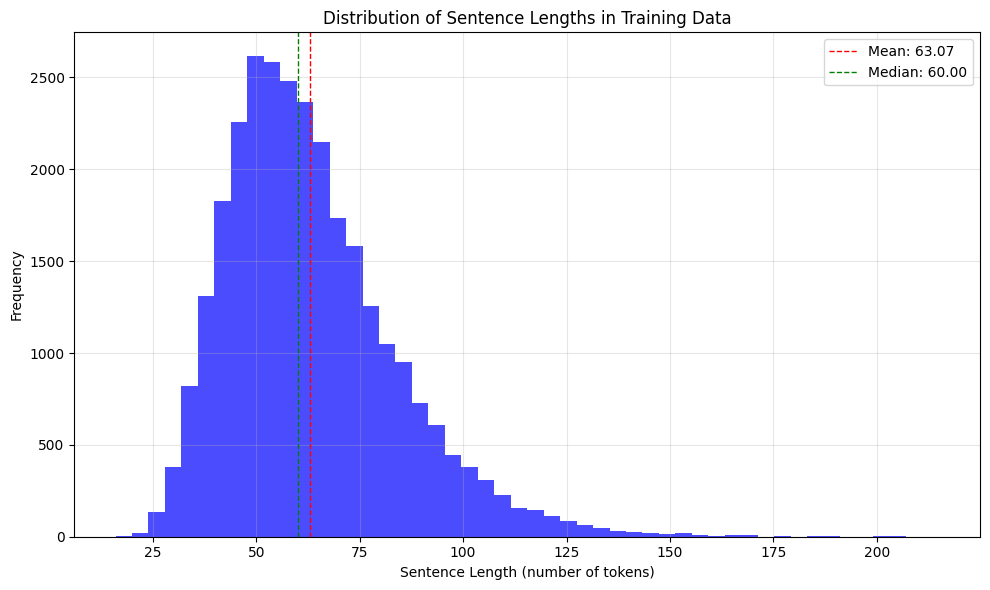

In [4]:
# 读取训练源文件并分析句子长度
with open("wmt16/train_trg.bpe", "r", encoding="utf8") as file:
    lines = file.readlines()

# 分割每行并计算长度
lengths = [len(line.strip()) for line in lines]

# 创建句子长度的直方图
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50, alpha=0.7, color='blue')
plt.xlabel('Sentence Length (number of tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths in Training Data')
plt.grid(True, alpha=0.3)

# 添加一些统计数据作为文本
plt.axvline(np.mean(lengths), color='r', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(lengths):.2f}')
plt.axvline(np.median(lengths), color='g', linestyle='dashed', linewidth=1, label=f'Median: {np.median(lengths):.2f}')
plt.legend()

# 显示一些统计数据
print(f"Total sentences: {len(lengths)}")
print(f"Min length: {min(lengths)}")
print(f"Max length: {max(lengths)}")
print(f"Mean length: {np.mean(lengths):.2f}")
print(f"Median length: {np.median(lengths)}")

plt.tight_layout()
plt.show()


# LangPairDataset

In [5]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader



class LangPairDataset(Dataset):

    def __init__(
        self, mode="train", max_length=273, overwrite_cache=False, data_dir="wmt16",
    ):
        self.data_dir = Path(data_dir) #封装为path对象
        cache_path = self.data_dir / ".cache" / f"de2en_{mode}_{max_length}.npy" # 缓存路径

        if overwrite_cache or not cache_path.exists(): #判断是否需要覆盖缓存，或者缓存文件不存在
            cache_path.parent.mkdir(parents=True, exist_ok=True) # 创建缓存目录

            with open(self.data_dir / f"{mode}_src.bpe", "r", encoding="utf8") as file:
                self.src = file.readlines() # 读取源语言文件所有行

            with open(self.data_dir / f"{mode}_trg.bpe", "r", encoding="utf8") as file:
                self.trg = file.readlines() # 读取目标语言文件所有行

            filtered_src = [] # 过滤后的源语言数据
            filtered_trg = [] # 过滤后的目标语言数据
            # max length filter,超出最大长度的句子舍弃
            for src, trg in zip(self.src, self.trg):
                if len(src) <= max_length and len(trg) <= max_length: # 过滤长度超过最大长度的句子
                    filtered_src.append(src.strip()) # 去掉句子前后的空格
                    filtered_trg.append(trg.strip())
            filtered_src = np.array(filtered_src)
            filtered_trg = np.array(filtered_trg)
            np.save(
                cache_path,
                {"src": filtered_src, "trg": filtered_trg },
                allow_pickle=True,
            )#allow_pickle=True允许保存对象数组，将过滤后的数据保存为 NumPy 数组，存储在缓存文件中
            print(f"save cache to {cache_path}")

        else:
            cache_dict = np.load(cache_path, allow_pickle=True).item() #allow_pickle=True允许保存对象数组
            print(f"load {mode} dataset from {cache_path}")
            filtered_src = cache_dict["src"] # 加载缓存文件中保存的源语言数据
            filtered_trg = cache_dict["trg"] # 加载缓存文件中保存的目标语言数据

        self.src = filtered_src
        self.trg = filtered_trg

    def __getitem__(self, index):
        return self.src[index], self.trg[index]

    def __len__(self):
        return len(self.src)


train_ds = LangPairDataset("train")
val_ds = LangPairDataset("val")

load train dataset from wmt16\.cache\de2en_train_273.npy
load val dataset from wmt16\.cache\de2en_val_273.npy


In [6]:
len(train_ds)

29000

# Tokenizer

In [7]:
#载入词表，看下词表长度，词表就像英语字典,构建word2idx和idx2word
word2idx = {
    "[PAD]": 0,     # 填充 token
    "[BOS]": 1,     # begin of sentence
    "[UNK]": 2,     # 未知 token
    "[EOS]": 3,     # end of sentence
}
idx2word = {value: key for key, value in word2idx.items()}
index = len(idx2word)
threshold = 1  # 出现次数低于此的token舍弃

with open("wmt16/vocab", "r", encoding="utf8") as file:  # 打开词汇表文件进行读取，使用utf8编码
    for line in tqdm(file.readlines()):  # 使用tqdm显示进度条，遍历文件的每一行
        token, counts = line.strip().split()  # 去除每行两端的空白字符并按空格分割为token和出现次数
        if int(counts) >= threshold:  # 判断token的出现次数是否大于或等于阈值
            word2idx[token] = index  # 将token添加到word2idx字典，建立token到索引的映射
            idx2word[index] = token  # 将token添加到idx2word字典，建立索引到token的映射
            index += 1  # 索引值增加1，为下一个token准备

vocab_size = len(word2idx)  # 计算词表大小，即word2idx字典中的条目数量
print("vocab_size: {}".format(vocab_size))  # 打印词表大小


  0%|          | 0/18107 [00:00<?, ?it/s]

vocab_size: 18111


# Tokenizer

In [8]:
class Tokenizer:
    def __init__(self, word2idx, idx2word, max_length=128, pad_idx=0, bos_idx=1, eos_idx=3, unk_idx=2):
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.max_length = max_length
        self.pad_idx = pad_idx
        self.bos_idx = bos_idx
        self.eos_idx = eos_idx
        self.unk_idx = unk_idx

    def encode(self, text_list, padding_first=False, add_bos=True, add_eos=True, return_mask=False):
        """如果padding_first == True，则padding加载前面，否则加载后面"""
        max_length = min(self.max_length, add_eos + add_bos + max([len(text) for text in text_list])) # 取min(max_length, 句子长度+add_bos+add_eos)
        indices_list = []
        #text_list是句子列表，每个句子是一个单词列表,text_list是一个批次
        for text in text_list:
            indices = [self.word2idx.get(word, self.unk_idx) for word in text[:max_length - add_bos - add_eos]] # 取前max_length-add_bos-add_eos个单词，如果单词不在词典中，则用unk_idx代替
            if add_bos:#如果add_bos == True，则添加[BOS]
                indices = [self.bos_idx] + indices
            if add_eos:#如果add_eos == True，则添加[EOS]
                indices = indices + [self.eos_idx]
            if padding_first:#如果padding_first == True，则padding加载前面，否则加载后面
                indices = [self.pad_idx] * (max_length - len(indices)) + indices # padding加载前面
            else:
                indices = indices + [self.pad_idx] * (max_length - len(indices)) # padding加载后面
            indices_list.append(indices)
        input_ids = torch.tensor(indices_list)
        masks = (input_ids == self.pad_idx).to(dtype=torch.int64) # 为了方便损失计算，这里的mask为0的地方需要计算，为1的地方不需要计算
        return input_ids if not return_mask else (input_ids, masks) #返回input_ids和mask


    def decode(self, indices_list, remove_bos=True, remove_eos=True, remove_pad=True, split=False):
        text_list = []
        for indices in indices_list:
            text = []
            for index in indices:
                word = self.idx2word.get(index, "[UNK]")
                if remove_bos and word == "[BOS]":
                    continue
                if remove_eos and word == "[EOS]":
                    break
                if remove_pad and word == "[PAD]":
                    break
                text.append(word)
            text_list.append(" ".join(text) if not split else text) #如果split == True，则返回一个单词列表，否则返回一个句子
        return text_list #返回一个句子列表


tokenizer = Tokenizer(word2idx=word2idx, idx2word=idx2word)


raw_text = ["hello world".split(), "a little boy playing gam@@ e@@ cu@@ be at a mcdonald &apos;s .".split(), "this is a test".split()]
indices = tokenizer.encode(raw_text, padding_first=False, add_bos=True, add_eos=True)
decode_text = tokenizer.decode(indices.tolist(), remove_bos=False, remove_eos=False, remove_pad=False) # 这里的remove_bos、remove_eos、remove_pad都为False，所以返回的句子中包含[BOS]、[EOS]和[PAD]
print("raw text")
for raw in raw_text:
    print(raw)
print("indices")
for index in indices:
    print(index)
print("decode text")
for decode in decode_text:
    print(decode)

raw text
['hello', 'world']
['a', 'little', 'boy', 'playing', 'gam@@', 'e@@', 'cu@@', 'be', 'at', 'a', 'mcdonald', '&apos;s', '.']
['this', 'is', 'a', 'test']
indices
tensor([   1, 9458, 3522,    3,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])
tensor([   1,    5,  105,   56,   63, 8664,  732, 2716,  414,   35,    5, 4016,
         192,    4,    3])
tensor([   1,  385,   18,    5, 5699,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0])
decode text
[BOS] hello world [EOS] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[BOS] a little boy playing gam@@ e@@ cu@@ be at a mcdonald &apos;s . [EOS]
[BOS] this is a test [EOS] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [9]:
class SampleInfo: #下面的info对象
    def __init__(self, i, lens):
        """
        记录文本对的序号和长度信息
        输入：
            - i (int): 文本对的序号。
            - lens (list): 文本对源语言和目标语言的长度
        """
        self.i = i
        # 加一是考虑填补在文本前后的特殊词元，lens[0]和lens[1]分别表示源语言和目标语言的长度
        self.max_len = max(lens[0], lens[1]) + 1
        self.src_len = lens[0] + 1
        self.trg_len = lens[1] + 1

# 一个批量生成器，根据词元数目的限制来控制批量的大小。它会根据传入的样本信息，在不超过设定大小的情况下，逐步构建批量。
#就是箱子
class TokenBatchCreator:
    def __init__(self, batch_size):
        """
        参数:
        batch_size (int): 用于限制批量的大小。箱子大小 高*宽
        功能:
        初始化了一个空的批量列表 _batch。
        设定了初始的最大长度为 -1。
        存储了传入的 batch_size。
        """

        self.__batch = []  #这个就是之前的batch_size，就是第一个batch内有多少个样本,私有属性
        self.max_len = -1  #箱子内最长的样本长度
        self._batch_size = batch_size # 限制批量的大小,假设是4096

    def append(self, info: SampleInfo):
        """
        参数:
        info (SampleInfo): 文本对的信息。
        功能:
        接收一个 SampleInfo 对象，并根据其最大长度信息更新当前批量的最大长度。
        如果将新的样本加入批量后超过了批量大小限制，它会返回已有的批量并将新的样本加入新的批量。
        否则，它会更新最大长度并将样本添加到当前批量中。
        """
        # 更新当前批量的最大长度
        cur_len = info.max_len # 当前样本的长度
        max_len = max(self.max_len, cur_len) # 每来一个样本，更新当前批次的最大长度
        # 如果新的样本加入批量后超过大小限制，则将已有的批量返回，新的样本加入新的批量
        if max_len * (len(self.__batch) + 1) > self._batch_size: # 这里的len(self.__batch) + 1是因为当前batch还没有满
            self.__batch, result = [], self.__batch # 保存当前的batch，并返回,这里的result是之前的batch,_batch清空
            self.__batch.append(info) #箱子里的第一条样本，放入
            self.max_len = cur_len #因为是当前batch的第一个样本，所以它的长度就是当前长度
            return result
        else:
            self.max_len = max_len
            self.__batch.append(info) # 将样本添加到当前批量中
            return None

    @property # 装饰器，将方法变成属性，可以直接访问属性
    def batch(self):
        return self.__batch # 返回当前的批量

In [16]:
# 当一个自定义对象可以iter(自定义对象)时，会自动调用__iter__方法
from torch.utils.data import BatchSampler
import numpy as np


class TransformerBatchSampler(BatchSampler):
    def __init__(self,
                 dataset,
                 batch_size,
                 shuffle_batch=False,
                 clip_last_batch=False,
                 seed=0):
        """
        批量采样器
        输入:
            - dataset: 数据集
            - batch_size: 批量大小
            - shuffle_batch: 是否对生成的批量进行洗牌
            - clip_last_batch: 是否裁剪最后剩下的数据
            - seed: 随机数种子
        """
        self._dataset = dataset #数据集
        self._batch_size = batch_size #箱子大小
        self._shuffle_batch = shuffle_batch #是否打乱箱子
        self._clip_last_batch = clip_last_batch #是否裁剪最后剩下的数据
        self._seed = seed #下面3个是为了随机
        self._random = np.random
        self._random.seed(seed)

        self._sample_infos = [] #所有样本信息
        # 根据数据集中的每个样本，创建了对应的 SampleInfo 对象，包含了样本的索引和长度信息。
        for i, data in enumerate(self._dataset):
            lens = [len(data[0]), len(data[1])] #输入和输出的长度计算放到lens中
            self._sample_infos.append(SampleInfo(i, lens)) #每个样本信息

    def __iter__(self):
        """
        对数据集中的样本进行排序，排序规则是先按源语言长度排序，如果相同则按目标语言长度排序。
        使用 TokenBatchCreator 逐步组装批量数据，当满足批量大小时返回一个批量的样本信息。
        如果不裁剪最后一个批次的数据且存在剩余样本，则将这些样本组成最后一个批次。
        如果需要对批量进行洗牌，则对批次进行洗牌操作。
        通过迭代器，抛出每个批量的样本在数据集中的索引。
        """
        # 排序，如果源语言长度相同则按照目标语言的长度排列
        infos = sorted(self._sample_infos,
                       key=lambda x: (x.src_len, x.trg_len))
        # 把样本放入到箱子里，所有装箱后的箱子，每一个箱子都放入batch_infos
        batch_infos = [] #放箱子的列表，每个箱子都是一个batch
        batch_creator = TokenBatchCreator(self._batch_size) # 批量生成器,上面自定义的类
        for info in infos:
            batch = batch_creator.append(info)
            # 存够一个batch的样本信息后，会把这个batch返回，否则返回为None
            if batch is not None:
                batch_infos.append(batch)

        # 是否抛弃最后批量的文本对
        if not self._clip_last_batch and len(batch_creator.batch) != 0:
            batch_infos.append(batch_creator.batch) # 最后一个batch

        # 打乱batch，打乱的是箱子的顺序
        if self._shuffle_batch:
            self._random.shuffle(batch_infos)

        self.batch_number = len(batch_infos) #箱子数量
        # print(self.batch_number) #为了理解

        # 抛出一个箱子里所有样本的序号
        for batch in batch_infos:
            batch_indices = [info.i for info in batch] # 批量的样本在数据集中的索引，第一个batch[0,1,.....82]，第二个batch[83,84,85,86,87]
            yield batch_indices

    def __len__(self):
        """
        返回批量的数量
        """
        if hasattr(self, "batch_number"): # 如果有batch_number属性，说明已经计算过了，直接返回
            return self.batch_number
        # 计算批量的数量,没有用到下面的情况，不用看
        batch_number = (len(self._dataset) +
                        self._batch_size) // self._batch_size
        return batch_number

In [17]:
sampler = TransformerBatchSampler(train_ds, batch_size=4096, shuffle_batch=True)

#为什么这里每个批量的样本对数目不一样呢？长度*batch_number>4096的时候，就会返回上一个batch，然后新的样本加入新的batch,具体要看TokenBatchCreator的44行

In [18]:
for idx, batch in enumerate(sampler):
    print("第{}批量的数据中含有文本对是：{}，数量为：{}".format(idx, batch, len(batch)))
    if idx >= 3:
        break

第0批量的数据中含有文本对是：[9107, 10753, 16443, 26511, 23197, 27561, 2289, 28887, 25321, 8029, 1921, 27881, 804, 12064, 4937, 10825, 20403, 21794, 1011, 11803, 2743, 11033, 21357, 6787, 27264, 24877, 28554, 28675, 3377, 720, 7005]，数量为：31
第1批量的数据中含有文本对是：[5251, 13027, 19187, 26133, 28219, 1603, 6469, 12633, 4423, 17585, 17839, 26877, 1837, 12925, 24569, 26581, 28167, 7385, 10885, 23498, 18862, 23462, 27539, 28513, 533, 22235, 2703, 2989, 20677, 24901, 25655, 1631, 2787, 6371, 27971, 3739, 4581, 16081, 19849]，数量为：39
第2批量的数据中含有文本对是：[26411, 10977, 22298, 2891, 15917, 8851, 9821, 24257, 12999, 10377, 18307, 2565, 26629, 28413, 12829, 3867, 10870, 4304, 17287, 16943, 20464, 21188, 24115, 14887, 17821, 20591, 2646, 6597, 9033, 25028, 27781, 16803]，数量为：32
第3批量的数据中含有文本对是：[14339, 20611, 21119, 21529, 21787, 23915, 24563, 24662, 27601, 2091, 2613, 2925, 3041, 3343, 4832, 6515, 13400, 16301, 16528, 18399, 21962, 27328, 28576, 3310, 4486, 5364, 7775, 8276, 10173, 10430, 11393, 11875, 13854, 15481, 19081, 19421,

# DataLoader

In [ ]:
def collate_fct(batch, tokenizer):
    """数据批处理函数,用于将原始数据转换为模型输入格式
    Args:
        batch: 包含源语言和目标语言句子对的批次数据
        tokenizer: 分词器对象
    Returns:
        返回编码后的张量字典,包含编码器输入、解码器输入和标签等
    """
    # 将每个句子对分割成单词列表
    src_words = [pair[0].split() for pair in batch]  # 源语言单词列表
    trg_words = [pair[1].split() for pair in batch]  # 目标语言单词列表

    # 编码器输入: [BOS] src [EOS] [PAD]
    # 添加开始符[BOS]和结束符[EOS],并进行padding,同时返回mask
    encoder_inputs, encoder_inputs_mask = tokenizer.encode(
        src_words, padding_first=False, add_bos=True, add_eos=True, return_mask=True #padding_first=False表示不进行padding,返回mask
        )

    # 解码器输入: [BOS] trg [PAD]
    # 只添加开始符[BOS],不添加结束符[EOS]
    decoder_inputs = tokenizer.encode(
        trg_words, padding_first=False, add_bos=True, add_eos=False, return_mask=False,
        )

    # 解码器标签: trg [EOS] [PAD]
    # 只添加结束符[EOS],不添加开始符[BOS]
    decoder_labels, decoder_labels_mask = tokenizer.encode(
        trg_words, padding_first=False, add_bos=False, add_eos=True, return_mask=True
        )

    # 将所有张量移动到指定设备(CPU/GPU)上
    return {
        "encoder_inputs": encoder_inputs.to(device=device),           # 编码器输入序列
        "encoder_inputs_mask": encoder_inputs_mask.to(device=device), # 编码器输入mask
        "decoder_inputs": decoder_inputs.to(device=device),           # 解码器输入序列
        "decoder_labels": decoder_labels.to(device=device),           # 解码器标签序列
        "decoder_labels_mask": decoder_labels_mask.to(device=device), # 解码器标签mask
    }

In [20]:
from functools import partial # 固定collate_fct的tokenizer参数

#可以调大batch_size,来看最终的bleu，如果GPU内存不够，可以减小batch_size
sampler = TransformerBatchSampler(train_ds, batch_size=256, shuffle_batch=True)
# https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
sample_dl = DataLoader(train_ds, batch_sampler=sampler, collate_fn=partial(collate_fct, tokenizer=tokenizer)) #partial函数，固定collate_fct的tokenizer参数,这里没有batch_size参数，因为batch_sampler已经指定了batch_size    

for batch in sample_dl:#外层是拿每个batch
    for key, value in batch.items():#内层是拿每个batch里面是一个字典
        print(key)
        print(value)
    break

encoder_inputs
tensor([[   1,   11,  591,   25,   12,    7,   17,  589,    9, 1757,  196,   27,
           67,  852, 2352,    4,    3],
        [   1,    7,   17,   13,  488,  157,    9,   24,    7, 1242,   73,   12,
          198, 1094,  308,    4,    3],
        [   1,   29,   58,   12,   11,   25,   97,   14,    8,  926,   12, 1145,
          625,    4,    3,    0,    0]])
encoder_inputs_mask
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]])
decoder_inputs
tensor([[  1,   5,  38, 331,  91,  19,   5,  16, 462,  32, 950,  10,  66,   4,
           0],
        [  1,   5,  16,   6,   5,  45, 157, 109,  69, 113, 364, 265,   5, 757,
           4],
        [  1,  28, 684,  19,   5,  26,  62,  19, 222,   6,   5, 844,   4,   0,
           0]])
decoder_labels
tensor([[  5,  38, 331,  91,  19,   5,  16, 462,  32, 950,  10,  66,   4,   3,
           0],
        [ 

# 定义模型

- Transformer模型由Embedding、Transformer-Block组成
- Embedding包括：
    - WordEmbedding
    - PositionEmbedding
- 多头注意力
- Transformer-Block包括：
    - Self-Attention
    - Cross-Attention
    - MLP

In [ ]:
#先对数后指数函数的例子
import torch
import math

def positional_encoding_weights(emb_size):
    # 计算底数和指数
    base = math.log(10000)
    exponent = -5 / emb_size
    
    # 应用指数函数
    # 将 base 转换为 tensor，因为 torch.exp 需要 tensor 类型的输入
    weight = torch.exp(torch.tensor(base)*exponent)
    
    return weight

emb_size = 10  # 举例，可以替换成你需要的大小
weight = positional_encoding_weights(emb_size)
print(weight)

tensor(0.0100)


In [43]:
import torch
import torch.nn as nn
import math

class TransformerEmbedding(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.vocab_size = config["vocab_size"]
        self.hidden_size = config["d_model"]  # 词向量维度
        self.pad_idx = config["pad_idx"]
        self.max_length = config["max_length"] # 最大token长度
        dropout_rate = config["dropout"]  # 随机失活率
        
        # 词嵌入层
        self.word_embedding = nn.Embedding(
            num_embeddings=self.vocab_size, # 词表大小
            embedding_dim=self.hidden_size, # 词向量维度
            padding_idx=self.pad_idx # 填充索引
        )
        
        # 位置编码层 - 不需要训练 
        self.position_embedding = nn.Embedding(
            num_embeddings=self.max_length,
            embedding_dim=self.hidden_size
        )
        
        # 初始化位置编码，固定不训练
        self.register_buffer(
            "position_ids", torch.arange(self.max_length).expand((1, -1))  # (1, max_length)
        )
        self.position_embedding.weight.requires_grad = False # 位置编码不需要训练
        self._init_position_encoding() # 初始化位置编码
        
        self.dropout = nn.Dropout(dropout_rate) # 随机失活层,是一个超参
        
    def _init_position_encoding(self):
        """初始化位置编码权重"""
        position = torch.arange(self.max_length).unsqueeze(1) #unsqueeze增加维度
        # print(f"Position shape: {position.shape}")  # 打印position张量形状是(max_length, 1)
        
        div_term = torch.exp(torch.arange(0, self.hidden_size, 2) * (-math.log(10000.0) / self.hidden_size))
        # print(f"Div_term shape: {div_term.shape}")  # 打印div_term张量形状是(hidden_size/2,)
        
        position_encoding = torch.zeros(self.max_length, self.hidden_size)
        # print(f"Position encoding initial shape: {position_encoding.shape}")  # 打印初始position_encoding形状是(max_length, hidden_size)
        
        position_encoding[:, 0::2] = torch.sin(position * div_term)
        position_encoding[:, 1::2] = torch.cos(position * div_term)
        
        # print(f"Final position encoding shape: {position_encoding.shape}")  # 打印最终position_encoding形状是(max_length, hidden_size)
        
        self.position_embedding.weight.data.copy_(position_encoding)
    
    def forward(self, x):
        # print(f"\n输入x的形状: {x.shape}")  # (batch_size, seq_length)
        
        seq_length = x.size(1)
        
        # 词嵌入
        word_embeddings = self.word_embedding(x)
        # print(f"词嵌入后的形状: {word_embeddings.shape}")  # (batch_size, seq_length, hidden_size)
        
        # 位置编码
        position_ids = self.position_ids[:, :seq_length]
        # print(f"位置编码ids的形状: {position_ids.shape}")  # (1, seq_length)
        
        position_embeddings = self.position_embedding(position_ids)
        # print(f"位置编码嵌入后的形状: {position_embeddings.shape}")  # (1, seq_length, hidden_size)
        
        # 词嵌入 + 位置编码
        embeddings = word_embeddings + position_embeddings
        # print(f"最终嵌入的形状: {embeddings.shape}")  # (batch_size, seq_length, hidden_size)
        
        # 应用dropout
        embeddings = self.dropout(embeddings)
        
        return embeddings

In [38]:
# 初始化TransformerEmbedding并进行前向计算
config = {
    'vocab_size': 30000,
    'd_model': 128,
    'max_length': 64,
    'pad_idx': 0,
    'dropout': 0.1,
}

# 创建模型实例
embedding_model = TransformerEmbedding(config=config)

# 创建一个示例输入 (batch_size=2, seq_length=10)
sample_input = torch.randint(0, config['vocab_size'], (2, 10))
print(f"输入形状: {sample_input.shape}")

# 前向计算
output = embedding_model(sample_input)
print(f"输出形状: {output.shape}")

Position shape: torch.Size([64, 1])
Div_term shape: torch.Size([64])
Position encoding initial shape: torch.Size([64, 128])
Final position encoding shape: torch.Size([64, 128])
输入形状: torch.Size([2, 10])

输入x的形状: torch.Size([2, 10])
词嵌入后的形状: torch.Size([2, 10, 128])
位置编码ids的形状: torch.Size([1, 10])
位置编码嵌入后的形状: torch.Size([1, 10, 128])
最终嵌入的形状: torch.Size([2, 10, 128])
输出形状: torch.Size([2, 10, 128])


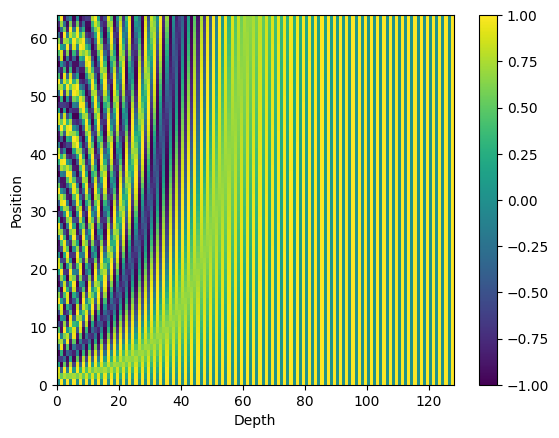

In [44]:
def plot_position_embedding(position_embedding):# 绘制位置编码
    plt.pcolormesh(position_embedding) # 绘制位置编码矩阵
    plt.xlabel('Depth')
    plt.ylabel('Position')
    plt.colorbar() # 颜色条，-1到1的颜色范围
    plt.show()

# 创建TransformerEmbedding实例并绘制位置编码
config = {
    'vocab_size': 30000,
    'd_model': 128,
    'max_length': 64,
    'pad_idx':0,
    'dropout':0.1,
}
embedding_model = TransformerEmbedding(config=config) # 创建TransformerEmbedding实例
position_embedding_data = embedding_model.position_embedding.weight.data # 获得位置编码数据
plot_position_embedding(position_embedding_data) # 绘制位置编码